In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import numpy as np
from scipy.interpolate import make_interp_spline
from sklearn.model_selection import train_test_split
%matplotlib inline

In [4]:
df = pd.read_csv('GDSC1_melanoma_BRAF_5conc_noreps_v3.csv')
X = df[['DRUG_ID', 'SCAN_DRUGID_COSMICID_KEY', 'COSMIC_ID','param_1', 'param_2', 'param_3',
       'param_4','ARID1A_mut', 'ARID2_mut', 'BRAF_mut', 'CDKN2A_mut',
       'EZH2_mut', 'MECOM_mut', 'NF1_mut', 'NRAS_mut', 'PLCB1_mut', 'PTEN_mut',
       'TP53_mut', 'loss.cnaSKCM3', 'loss.cnaSKCM4..BNC2.CDKN2A.JAK2.PSIP1.',
       'loss.cnaSKCM5..PAX5.', 'loss.cnaSKCM9', 'gain.cnaSKCM12..KRAS.',
       'gain.cnaSKCM21..FOXP1.MITF.', 'loss.cnaSKCM22', 'loss.cnaSKCM23',
       'loss.cnaSKCM24..loss.cnaSKCM25', 'loss.cnaSKCM26',
       'loss.cnaSKCM27..CASP1.', 'loss.cnaSKCM28', 'loss.cnaSKCM30']].values
y = df[['norm_cells_1', 'norm_cells_2', 'norm_cells_3',
       'norm_cells_4', 'norm_cells_5']].values

print(X.shape)
print(y.shape)
num_conc=y.shape[1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

X_train = np.array(X_train, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)
X_test = np.array(X_test, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)

(80, 31)
(80, 5)


In [5]:
X_train_tensor = torch.tensor(X_train)
y_train_tensor = torch.tensor(y_train)
X_test_tensor = torch.tensor(X_train)
y_test_tensor = torch.tensor(y_test)

In [6]:
class BatchIndependentMultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean(batch_shape=torch.Size([num_conc]))
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(batch_shape=torch.Size([num_conc])),
            batch_shape=torch.Size([num_conc])
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal.from_batch_mvn(
            gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
        )


likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=num_conc)
model = BatchIndependentMultitaskGPModel(X_train_tensor, y_train_tensor, likelihood)

In [7]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iterations = 2 if smoke_test else 50


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(X_test_tensor)
    loss = -mll(output, y_train_tensor)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
    optimizer.step()

Iter 1/50 - Loss: 1.353
Iter 2/50 - Loss: 1.300
Iter 3/50 - Loss: 1.249
Iter 4/50 - Loss: 1.199
Iter 5/50 - Loss: 1.152
Iter 6/50 - Loss: 1.108
Iter 7/50 - Loss: 1.066
Iter 8/50 - Loss: 1.028
Iter 9/50 - Loss: 0.992
Iter 10/50 - Loss: 0.956
Iter 11/50 - Loss: 0.920
Iter 12/50 - Loss: 0.882
Iter 13/50 - Loss: 0.841
Iter 14/50 - Loss: 0.799
Iter 15/50 - Loss: 0.757
Iter 16/50 - Loss: 0.714
Iter 17/50 - Loss: 0.673
Iter 18/50 - Loss: 0.634
Iter 19/50 - Loss: 0.596
Iter 20/50 - Loss: 0.558
Iter 21/50 - Loss: 0.522
Iter 22/50 - Loss: 0.486
Iter 23/50 - Loss: 0.451
Iter 24/50 - Loss: 0.417
Iter 25/50 - Loss: 0.384
Iter 26/50 - Loss: 0.353
Iter 27/50 - Loss: 0.323
Iter 28/50 - Loss: 0.297
Iter 29/50 - Loss: 0.274
Iter 30/50 - Loss: 0.253
Iter 31/50 - Loss: 0.232
Iter 32/50 - Loss: 0.214
Iter 33/50 - Loss: 0.199
Iter 34/50 - Loss: 0.189
Iter 35/50 - Loss: 0.181
Iter 36/50 - Loss: 0.173
Iter 37/50 - Loss: 0.168
Iter 38/50 - Loss: 0.166
Iter 39/50 - Loss: 0.165
Iter 40/50 - Loss: 0.165
Iter 41/5

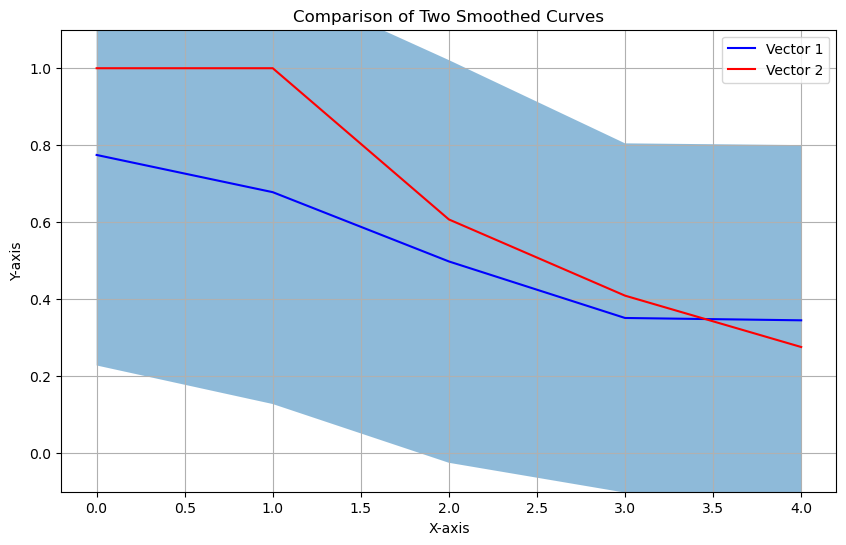

In [8]:
def smooth_curve(x, y, num_points=300):
    # 创建平滑的曲线
    x_smooth = np.linspace(x.min(), x.max(), num_points)
    y_smooth = make_interp_spline(x, y)(x_smooth)
    return x_smooth, y_smooth

# Set into eval mode
model.eval()
likelihood.eval()


# Make predictions
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = X_test_tensor[1:2]
    predictions = likelihood(model(test_x))
    mean = predictions.mean
    lower, upper = predictions.confidence_region()

x = np.arange(len(mean[0]))
y_pred=mean[0]
y_true=y_test_tensor[1]

x = np.linspace(0, len(y_pred) - 1, len(y_pred))


# 创建图形
plt.figure(figsize=(10, 6))
plt.plot(x, y_pred, label='Vector 1', color='blue')
plt.plot(x, y_true, label='Vector 2', color='red')
plt.fill_between(x, lower[0].numpy(), upper[0].numpy(), alpha=0.5)
plt.ylim(-0.1, 1.1)
# 添加标题和标签
plt.title('Comparison of Two Smoothed Curves')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.grid(True)

